# Step 1.1: Track Visualization and Car Simulation

**Objective:**  
Load telemetry data from CSV and visualize a single car's movement on the track map with animation.

**Instructions:**
- Load telemetry data from the exported CSV file
- Extract race location information
- Get track map from FastF1 using race location
- Filter data for one driver/car
- Plot the car's position on the track map
- Animate/simulate the car moving along the track using the telemetry data


In [66]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
import yaml
from pathlib import Path
from IPython.display import HTML, display

# Set matplotlib backend for Jupyter notebooks
%matplotlib inline

# FastF1 imports
try:
    import fastf1
    import fastf1.plotting
except ImportError:
    print("FastF1 not installed. Install with: pip install fastf1")
    sys.exit(1)

# Add project root directory to path
cwd = os.getcwd()
if os.path.basename(cwd) == 'notebooks':
    project_root = os.path.dirname(cwd)
else:
    project_root = cwd
    if not os.path.exists(os.path.join(project_root, 'src')):
        current = cwd
        while current != os.path.dirname(current):
            if os.path.exists(os.path.join(current, 'src')):
                project_root = current
                break
            current = os.path.dirname(current)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✅ Imports successful")


✅ Imports successful


In [67]:
# Load configuration to get race location
config_path = "../config/config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

race_config = config['race']
year = race_config['year']
grand_prix = race_config['grand_prix']
session = race_config['session']

print(f"Race Configuration:")
print(f"  Year: {year}")
print(f"  Grand Prix: {grand_prix}")
print(f"  Session: {session}")


Race Configuration:
  Year: 2023
  Grand Prix: Monaco
  Session: Race


In [68]:
# Find the most recent CSV file in the data directory
data_dir = "../data"
csv_files = list(Path(data_dir).glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {data_dir}")

# Get the most recent CSV file
latest_csv = max(csv_files, key=os.path.getctime)
print(f"Loading data from: {latest_csv}")

# Load CSV data
# Use low_memory=False to avoid dtype warnings
df = pd.read_csv(latest_csv, low_memory=False)

print(f"\n✅ Data loaded successfully")
print(f"Total records: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nAvailable drivers: {sorted(df['DriverID'].unique().tolist())}")
print(f"\nData columns: {list(df.columns)}")


Loading data from: ../data/2023_Monaco_Race_20251116_165413.csv

✅ Data loaded successfully
Total records: 982,330
Columns: 65

Available drivers: ['ALB', 'ALO', 'BOT', 'DEV', 'GAS', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO']

Data columns: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status_x', 'X', 'Y', 'Z', 'DriverID', 'Driver', 'LapNumber', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'LapStartTime', 'LapStartDate', 'PitOutTime', 'PitInTime', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Stint', 'TrackStatus', 'Position_x', 'Deleted', 'DeletedReason', 'LapTime_seconds', 'Sector2Time_seconds', 'Sector3Time_seconds', 'Sector2SessionTime_seconds', 'Sector3SessionTime_seconds', 'LapStartTime_seconds', 'Time_seconds', '

In [69]:
# Select a driver to visualize
# You can change this to any driver from the list above
selected_driver = 'VER'  # Max Verstappen

# Filter data for selected driver
driver_data = df[df['DriverID'] == selected_driver].copy()

if driver_data.empty:
    raise ValueError(f"No data found for driver {selected_driver}")

# Sort by SessionTime to ensure proper order
driver_data = driver_data.sort_values('SessionTime').reset_index(drop=True)

# Filter for first 2 laps only (for static visualization)
unique_laps = sorted(driver_data['LapNumber'].unique())
if len(unique_laps) >= 2:
    laps_to_show = unique_laps[:2]
    driver_data = driver_data[driver_data['LapNumber'].isin(laps_to_show)].copy()
    driver_data = driver_data.sort_values('SessionTime').reset_index(drop=True)
    print(f"✅ Filtered to first 2 laps: {laps_to_show[0]:.0f} and {laps_to_show[1]:.0f}")

# Check if X, Y coordinates are available
if 'X' not in driver_data.columns or 'Y' not in driver_data.columns:
    raise ValueError("X and Y coordinates not found in data. These are required for track visualization.")

print(f"✅ Filtered data for driver {selected_driver}")
print(f"Total data points: {len(driver_data):,}")
print(f"Laps covered: {driver_data['LapNumber'].min():.0f} to {driver_data['LapNumber'].max():.0f}")
print(f"Time range: {driver_data['SessionTime'].min():.2f}s to {driver_data['SessionTime'].max():.2f}s")
print(f"\nFirst few rows:")
driver_data[['SessionTime', 'LapNumber', 'X', 'Y', 'Speed', 'DriverID']].head()


✅ Filtered to first 2 laps: 1 and 2
✅ Filtered data for driver VER
Total data points: 1,271
Laps covered: 1 to 2
Time range: 3722.95s to 3886.53s

First few rows:


,SessionTime,LapNumber,X,Y,Speed,DriverID
0,3722.950,1.0,-7651.987565,-6772.105102,0.000000,VER
1,3723.048,1.0,-7651.978137,-6772.186036,0.000000,VER
2,3723.118,1.0,-7652.000000,-6772.000000,0.000000,VER
3,3723.328,1.0,-7652.206856,-6770.239820,0.000000,VER
4,3723.557,1.0,-7652.000000,-6773.000000,0.954167,VER


In [70]:
# Load FastF1 session to get track map
# Enable cache if available
cache_dir = "../../OLD_version/f1_cache"
if os.path.exists(cache_dir):
    fastf1.Cache.enable_cache(cache_dir)
    print(f"✅ Using cache directory: {cache_dir}")
else:
    print("⚠️  Cache directory not found, will download data")

print(f"\nLoading {year} {grand_prix} {session} session for track map...")
session_obj = fastf1.get_session(year, grand_prix, session)
session_obj.load()

print(f"✅ Session loaded successfully")
print(f"Track: {session_obj.event['Location']}")
print(f"Circuit: {session_obj.event.get('EventName', 'N/A')}")


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


✅ Using cache directory: ../../OLD_version/f1_cache

Loading 2023 Monaco Race session for track map...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']


✅ Session loaded successfully
Track: Monaco
Circuit: Monaco Grand Prix


In [71]:
# Get track coordinates from FastF1
# We'll use the circuit info to get the track layout
try:
    # Get circuit info
    circuit_info = session_obj.get_circuit_info()
    
    # Get track coordinates - FastF1 provides track coordinates in the circuit info
    # We can also get them from position data
    print("✅ Circuit info loaded")
    print(f"Track length: {circuit_info.track_length:.2f} km")
    
    # Get reference telemetry for track coordinates (from FastF1)
    # Use the first driver's telemetry to get the track layout
    reference_driver = session_obj.results['Abbreviation'].iloc[0]
    ref_laps = session_obj.laps.pick_driver(reference_driver)
    ref_telemetry = ref_laps.iloc[0].get_telemetry()
    
    # Extract track coordinates from reference telemetry
    track_x = ref_telemetry['X'].values
    track_y = ref_telemetry['Y'].values
    
    print(f"✅ Track coordinates extracted: {len(track_x)} points")
    
except Exception as e:
    print(f"⚠️  Could not get circuit info: {e}")
    print("Using data from CSV instead...")
    # Fallback: use the first driver's data to get track shape
    first_driver = df['DriverID'].iloc[0]
    track_data = df[df['DriverID'] == first_driver].sort_values('SessionTime')
    track_x = track_data['X'].values
    track_y = track_data['Y'].values
    print(f"✅ Using track coordinates from CSV: {len(track_x)} points")


✅ Circuit info loaded
⚠️  Could not get circuit info: 'CircuitInfo' object has no attribute 'track_length'
Using data from CSV instead...
✅ Using track coordinates from CSV: 49781 points


In [72]:
# Prepare driver position data
driver_x = driver_data['X'].values
driver_y = driver_data['Y'].values
driver_speed = driver_data['Speed'].values
driver_lap = driver_data['LapNumber'].values
driver_time = driver_data['SessionTime'].values

# Get driver info
driver_name = driver_data['FullName'].iloc[0] if 'FullName' in driver_data.columns else selected_driver
driver_team = driver_data['TeamName'].iloc[0] if 'TeamName' in driver_data.columns else 'Unknown'

print(f"Driver: {driver_name} ({selected_driver})")
print(f"Team: {driver_team}")
print(f"Position data points: {len(driver_x)}")
print(f"Speed range: {driver_speed.min():.1f} - {driver_speed.max():.1f} km/h")


Driver: Max Verstappen (VER)
Team: Red Bull Racing
Position data points: 1271
Speed range: 0.0 - 271.0 km/h


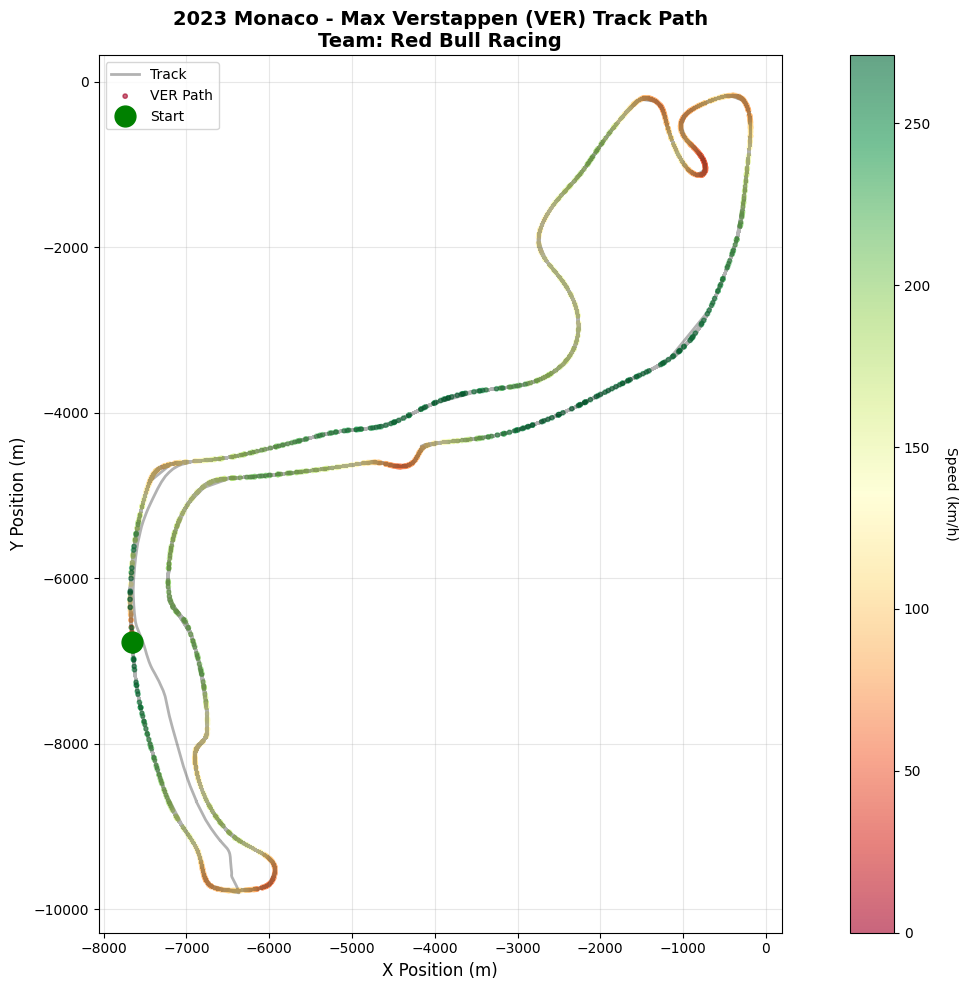

✅ Static track visualization complete


In [73]:
# Static plot: Show full track with driver's path
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the track outline
ax.plot(track_x, track_y, 'k-', linewidth=2, alpha=0.3, label='Track')

# Plot driver's complete path (color-coded by speed)
scatter = ax.scatter(driver_x, driver_y, c=driver_speed, cmap='RdYlGn', 
                     s=10, alpha=0.6, label=f'{selected_driver} Path')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Speed (km/h)', rotation=270, labelpad=20)

# Mark start/finish line (first point)
ax.plot(driver_x[0], driver_y[0], 'go', markersize=15, label='Start', zorder=5)

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.set_xlabel('X Position (m)', fontsize=12)
ax.set_ylabel('Y Position (m)', fontsize=12)
ax.set_title(f'{year} {grand_prix} - {driver_name} ({selected_driver}) Track Path\n'
             f'Team: {driver_team}', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Static track visualization complete")



## 🎬 Animated Track Visualization

**For animated visualization, please use the Streamlit app instead of matplotlib animations.**

Matplotlib animations in Jupyter notebooks are too large and slow. The Streamlit app provides a much better experience with smooth, interactive animations showing only the first 2 laps.

### Run the Streamlit Animation App:

```bash
cd "/Users/Ujjwal/Documents/DE Project/f1_streaming_pipeline"
streamlit run scripts/track_animation_streamlit.py
```

**Features of the Streamlit app:**
- ✅ Smooth real-time animation
- ✅ Shows only first 2 laps (as requested)
- ✅ Interactive controls (play/pause/reset)
- ✅ Adjustable animation speed
- ✅ Manual frame control
- ✅ Better performance than matplotlib animations
- ✅ No size limits or compilation issues


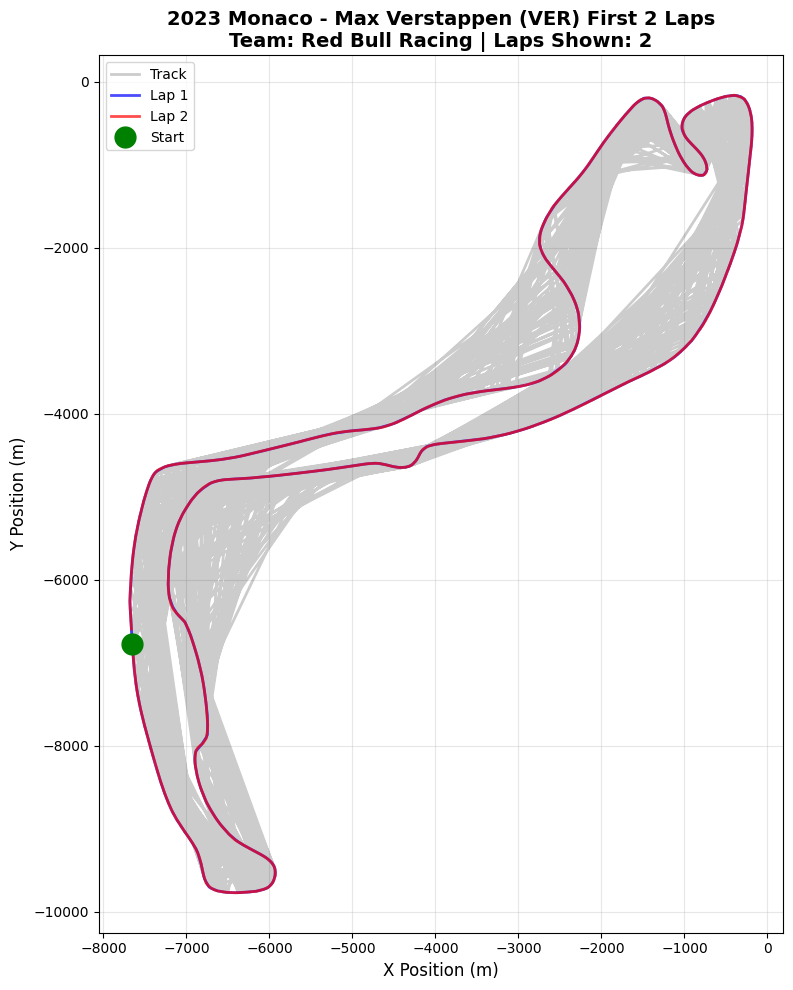

✅ First 2 laps visualization complete (Laps 1 and 2 shown)


In [74]:
# Enhanced visualization: Show first 2 laps with different colors
fig, ax = plt.subplots(figsize=(14, 10))

# Plot track
track_sample = max(1, len(track_x) // 1000)
ax.plot(track_x[::track_sample], track_y[::track_sample], 'k-', linewidth=2, alpha=0.2, label='Track')

# Plot each lap with different color (first 2 laps only)
unique_laps = sorted(driver_data['LapNumber'].unique())
colors = ['blue', 'red']  # Different colors for lap 1 and lap 2

for i, lap in enumerate(unique_laps[:2]):  # Only first 2 laps
    lap_data = driver_data[driver_data['LapNumber'] == lap]
    ax.plot(lap_data['X'], lap_data['Y'], '-', color=colors[i], 
           linewidth=2, alpha=0.7, label=f'Lap {lap:.0f}')

# Mark start/finish
ax.plot(driver_x[0], driver_y[0], 'go', markersize=15, label='Start', zorder=5)

ax.set_aspect('equal')
ax.set_xlabel('X Position (m)', fontsize=12)
ax.set_ylabel('Y Position (m)', fontsize=12)
ax.set_title(f'{year} {grand_prix} - {driver_name} ({selected_driver}) First 2 Laps\n'
             f'Team: {driver_team} | Laps Shown: {len(unique_laps[:2])}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ First 2 laps visualization complete (Laps {unique_laps[0]:.0f} and {unique_laps[1]:.0f} shown)")


In [75]:
# Summary statistics
print("=" * 60)
print(f"TRACK VISUALIZATION SUMMARY")
print("=" * 60)
print(f"Driver: {driver_name} ({selected_driver})")
print(f"Team: {driver_team}")
print(f"Track: {grand_prix}")
print(f"Session: {session}")
print(f"Year: {year}")
print(f"\nData Statistics:")
print(f"  Total data points: {len(driver_data):,}")
print(f"  Laps completed: {driver_data['LapNumber'].min():.0f} - {driver_data['LapNumber'].max():.0f}")
print(f"  Total laps: {len(unique_laps)}")
print(f"  Speed range: {driver_speed.min():.1f} - {driver_speed.max():.1f} km/h")
print(f"  Average speed: {driver_speed.mean():.1f} km/h")
print(f"  Time range: {driver_time.min():.2f}s - {driver_time.max():.2f}s")
print(f"  Total duration: {driver_time.max() - driver_time.min():.2f}s ({((driver_time.max() - driver_time.min())/60):.2f} minutes)")
print("\n✅ Track visualization and simulation complete!")


TRACK VISUALIZATION SUMMARY
Driver: Max Verstappen (VER)
Team: Red Bull Racing
Track: Monaco
Session: Race
Year: 2023

Data Statistics:
  Total data points: 1,271
  Laps completed: 1 - 2
  Total laps: 2
  Speed range: 0.0 - 271.0 km/h
  Average speed: 145.0 km/h
  Time range: 3722.95s - 3886.53s
  Total duration: 163.58s (2.73 minutes)

✅ Track visualization and simulation complete!
